# Object(text,images) detection/localization using RetinaNet, bounding box technique

---



In [0]:
# after running this cell restart your runtime
!pip install object-detection-fastai

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings('ignore')
import pdb

import json

import pandas as pd
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

### for resizing, preparing the JASON file, and other tasks required if the objects of interest for bounding box are give with their coordinates

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cbook as cbook
import math
import sys
import imageio
import os
import glob  # used for loading multiple files
# import PIL 

from pathlib import Path
# from PIL import Image  # if you import it this way, you will get attribute error, 
from PIL import Image as PilImage
import cv2
# from fastai import *
# from fastai.vision import *
# from fastai.callbacks.hooks import *
# from fastai.callbacks import SaveModelCallback
# from fastai.metrics import error_rate

# Resizing images before annotating them in VGG Image Annotator

In [0]:
                                                  
# from PIL import Image                                              
# import os, sys                       

# # path = Path(r"C:\Users\payman\Desktop\CompVision1\Project2_detectwords\train_sample_Resized")
# def resize():
#     for item in path.iterdir():
#       im = Image.open(item)
#       f, e = os.path.splitext(item)
#       # print(e)
#       imResize = im.resize((1024,1024), Image.ANTIALIAS)
# #       imResize = im.resize((2048,2048), Image.ANTIALIAS)
#       imResize.save(f+'.png', 'png')#, quality=80)

# resize()

# Reformating the cocoformat jason file that was exported from VIA software to a format that can be used in RetinaNet architecture

In [0]:
path = Path('/content/drive/My Drive/comp_vision/object_detection1')
list(path.iterdir())

[PosixPath('/content/drive/My Drive/comp_vision/object_detection1/annotations'),
 PosixPath('/content/drive/My Drive/comp_vision/object_detection1/train_sample'),
 PosixPath('/content/drive/My Drive/comp_vision/object_detection1/RetinaNet_BBox_wordDetection_working_Complete.ipynb')]

In [0]:
# My jason file to be formated 

annotpath = 'annotations'
data2 = json.load((path/annotpath/'Covid_SARS_WHO_wiki_article_cocoFormat.json').open())
data2.keys()

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])

# My own method of cleaning up the JASON file

In [0]:
data2.pop('info', None)
data2.pop('licenses', None)
data2.keys()

dict_keys(['images', 'annotations', 'categories'])

### Category key

In [0]:
data2['categories'][:4]

[{'id': 1, 'name': 'Name_ent', 'supercategory': 'shape'},
 {'id': 2, 'name': 'Pronoun', 'supercategory': 'shape'},
 {'id': 1, 'name': 'Name_ent', 'supercategory': 'shape'},
 {'id': 2, 'name': 'Pronoun', 'supercategory': 'shape'}]

In [0]:
data2['categories'] = [{'id': 1, 'name': 'Name_ent'}, {'id': 2, 'name': 'Pronoun'}]

### Image Key

In [0]:
i=0
data2['images'][i]

{'date_captured': '',
 'file_name': '1.png',
 'height': 2048,
 'id': 0,
 'license': 1,
 'width': 2048}

In [0]:
image_keys2 = ['file_name', 'id'] # The keys you want
for i in range(len(data2['images'])):
  data2['images'][i] = dict((k, data2['images'][i][k]) for k in image_keys2 if k in data2['images'][i])
  # print(data2['images'][i])

In [0]:
i=0
data2['images'][i]

{'file_name': '1.png', 'id': 0}

### match the id and file_name

In [0]:
# for i in range(len(data2['images'])):
#   fnum = data2['images'][i]['file_name'].split('.')[0].split("_")[1]
#   data2['images'][i]['id'] = fnum
#   # fname = fname.split('.')[0].split("_")[1]
#   # print(fname)                                      
#   # print(data2['images'][i]['id'])
#   # data2['images'][i]['id'] +=1

### Adding 1 to match the id and filename 

In [0]:
for i in range(len(data2['images'])):
  # print(data2['images'][i]['id']+1)
  data2['images'][i]['id'] +=1

In [0]:
data2['images'][10]

{'file_name': '11.png', 'id': 11}

### Annotation Key

In [0]:
data2['annotations'][:2]  # bbox list[column, row, height, width]

[{'area': 14105,
  'bbox': [950, 1095, 155, 91],
  'category_id': 2,
  'id': 0,
  'image_id': '0',
  'iscrowd': 0,
  'segmentation': [950, 1095, 1105, 1095, 1105, 1186, 950, 1186]},
 {'area': 19929,
  'bbox': [1176, 1708, 219, 91],
  'category_id': 1,
  'id': 1,
  'image_id': '0',
  'iscrowd': 0,
  'segmentation': [1176, 1708, 1395, 1708, 1395, 1799, 1176, 1799]}]

In [0]:
annot_keys2 = [ 'image_id','bbox', 'category_id']# The keys you want
for i in range(len(data2['annotations'])):
  data2['annotations'][i] = dict((k, data2['annotations'][i][k]) for k in annot_keys2 if k in data2['annotations'][i])
  # print(data2['annotations'][i])

In [0]:
# len(data2['annotations'])
data2['annotations'][:2]

[{'bbox': [950, 1095, 155, 91], 'category_id': 2, 'image_id': '0'},
 {'bbox': [1176, 1708, 219, 91], 'category_id': 1, 'image_id': '0'}]

In [0]:
for i in range(len(data2['annotations'])):
  data2['annotations'][i]['image_id'] = int(data2['annotations'][i]['image_id']) + 1

In [0]:
data2['annotations'][:2]

[{'bbox': [950, 1095, 155, 91], 'category_id': 2, 'image_id': 1},
 {'bbox': [1176, 1708, 219, 91], 'category_id': 1, 'image_id': 1}]

In [0]:
data2['annotations'][0]['image_id']

In [0]:
data2.keys()

dict_keys(['images', 'annotations', 'categories'])

In [0]:
data2_keys = ['categories', 'annotations', 'images']# The keys you want
data2 = dict((k,data2[k]) for k in data2_keys)

In [0]:
data2.keys()

dict_keys(['categories', 'annotations', 'images'])

## Save the new JASON file

In [0]:
with open('/content/drive/My Drive/comp_vision/object_detection1/annotations/Covid_SARS_WHO_wiki_article_cocoFormat_Modified.json', 'w') as fp:
    json.dump(data2, fp)

# format JASON structure by Howard in FastAi course, notebook Pascal  
https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb  

In [0]:
# My jason file to be formated 
path = Path('/content/drive/My Drive/comp_vision/object_detection1')
# o = list(path.iterdir())[0]
# str(o)
datapath = 'annotations'
data2 = json.load((path/datapath/'Covid_SARS_WHO_wiki_article_cocoFormat.json').open())
data2.keys()

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])

In [0]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
data2[IMAGES][:2]

[{'date_captured': '',
  'file_name': '1.png',
  'height': 2048,
  'id': 0,
  'license': 1,
  'width': 2048},
 {'date_captured': '',
  'file_name': '2.png',
  'height': 2048,
  'id': 1,
  'license': 1,
  'width': 2048}]

In [0]:
for i in range(len(data2[IMAGES])):
  # print(data2[IMAGES][i][ID]+1)
  data2[IMAGES][i][ID] +=1

In [0]:
data2[ANNOTATIONS][:2]

[{'area': 14105,
  'bbox': [950, 1095, 155, 91],
  'category_id': 2,
  'id': 0,
  'image_id': '0',
  'iscrowd': 0,
  'segmentation': [950, 1095, 1105, 1095, 1105, 1186, 950, 1186]},
 {'area': 19929,
  'bbox': [1176, 1708, 219, 91],
  'category_id': 1,
  'id': 1,
  'image_id': '0',
  'iscrowd': 0,
  'segmentation': [1176, 1708, 1395, 1708, 1395, 1799, 1176, 1799]}]

In [0]:
# for i in range(len(data2[ANNOTATIONS])):
#   data2[ANNOTATIONS][i]['image_id'] = int(data2[ANNOTATIONS][i]['image_id'])

In [0]:
for i in range(len(data2[ANNOTATIONS])):
  # print(str(int(data2[ANNOTATIONS][i]['image_id'])+1))
  data2[ANNOTATIONS][i]['image_id'] = int(data2[ANNOTATIONS][i]['image_id'])+1

In [0]:
data2[ANNOTATIONS][:2]

[{'area': 14105,
  'bbox': [950, 1095, 155, 91],
  'category_id': 2,
  'id': 0,
  'image_id': 1,
  'iscrowd': 0,
  'segmentation': [950, 1095, 1105, 1095, 1105, 1186, 950, 1186]},
 {'area': 19929,
  'bbox': [1176, 1708, 219, 91],
  'category_id': 1,
  'id': 1,
  'image_id': 1,
  'iscrowd': 0,
  'segmentation': [1176, 1708, 1395, 1708, 1395, 1799, 1176, 1799]}]

In [0]:
data2[CATEGORIES][:4]

[{'id': 1, 'name': 'Name_ent', 'supercategory': 'shape'},
 {'id': 2, 'name': 'Pronoun', 'supercategory': 'shape'},
 {'id': 1, 'name': 'Name_ent', 'supercategory': 'shape'},
 {'id': 2, 'name': 'Pronoun', 'supercategory': 'shape'}]

In [0]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in data2[CATEGORIES]} # dic of id and name from category dic
trn_fns = {o[ID]:o[FILE_NAME] for o in data2[IMAGES]}  # dic of id and file_name from image dic
trn_ids = [o[ID] for o in data2[IMAGES]]              # list of ids from image dict

In [0]:
imagepath = 'train_sample'

In [0]:
IMG_PATH = path/imagepath
list(IMG_PATH.iterdir())[:2]

[PosixPath('/content/drive/My Drive/comp_vision/object_detection1/train_sample/1.png'),
 PosixPath('/content/drive/My Drive/comp_vision/object_detection1/train_sample/12.png')]

In [0]:
# each image has a unique id
im0_d = data2[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

# defaultdict

#### "The standard dictionary includes the method setdefault() for retrieving a value and establishing a default if the value does not exist. By contrast, defaultdict lets the caller specify the default(value to be returned) up front when the container is initialized."  
Initialize defaultdict by passing a callable as its first argument(mandatory)

In [0]:
d_int = defaultdict(int)
d_int

defaultdict(int, {})

In [0]:
d_int.default_factory = lambda: 5
d_int['e']

5

In [0]:
kwargs = {'a':10,'b':12,'c':13}
d_int = defaultdict(int, **kwargs)
d_int

defaultdict(int, {'a': 10, 'b': 12, 'c': 13})

In [0]:
# data2[ANNOTATIONS][0][BBOX] -> x(columns), y(rows), w , h

def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])  # map the bbox coords: [Rows, columns, topleft, bottomright]
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1], a[2]-a[0]])       # inverse function for later 

trn_anno = collections.defaultdict(lambda:[]) # enter an empty list if calling a key that doesnt exit yet
for o in data2[ANNOTATIONS]:                  
    # if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)                        # map bbox
        # print(o[IMG_ID])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID])) # for each image id, append all instances of (bb and category_id), and if o[IMG_ID] doesnt exit create it as []
        
# len(trn_anno)

In [0]:
trn_anno[11]

[(array([546, 364, 629, 555]), 1),
 (array([ 229, 1108,  309, 1262]), 2),
 (array([ 674,  862,  744, 1019]), 2)]

In [0]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([1095,  950, 1185, 1104]), 2), (array([1708, 1176, 1798, 1394]), 1)]

In [0]:
im0_a = im_a[0]; im0_a

(array([1095,  950, 1185, 1104]), 2)

In [0]:
data2.pop('info', None)
data2.pop('licenses', None)
data2.keys()

dict_keys(['images', 'annotations', 'categories'])

In [0]:
with open('/content/drive/My Drive/comp_vision/object_detection1/annotations/Covid_SARS_WHO_wiki_article_withErros_cocoFormat_Modified.json', 'w') as fp:
    json.dump(data2, fp)

In [0]:
######################################################################################################################################################################################################################

# Model

In [0]:
### python debuger

"""

pdb.set_trace() : to set a break point

l: list the lines above and below
n: next line in code
s: step into the code ( such as into a function within a function)
p: print the output of a line
c: continue to or from the next break point!! 
u/d: up/down a level, or context, if you find yourself deep in layers, 
%debug : pops open the debuger at the point that exception happend.

"""

######################################################################################################################################################################################################################

# Setup the BBox Annotation info for the model


In [0]:
path = Path('/content/drive/My Drive/comp_vision/object_detection1')
imgpath = Path('/content/drive/My Drive/comp_vision/object_detection1/train_sample')
# list(imgpath.iterdir())
# list(path.iterdir())

In [0]:
data2 = json.load((path/'annotations/Covid_SARS_WHO_wiki_article_cocoFormat_Modified.json').open()) 
# data2.keys()

#### Function to get the annotations from JASON file  


In [0]:
# data2['annotations'][:3]

In [0]:
''' this line shows all image names collected by the jason export from VGG Image Annotator.'''
# l = [data2['images'][i]['file_name'] for i in range(len(data2['images']))]
''' this line shows that not all images do have annotations, which is not what happend when I annotated all images. anyways, I prefer to catch this before creating the data block '''
# l = [data2['annotations'][i]['image_id'] for i in range(len(data2['annotations']))]

In [0]:
def annotation_maper(fname, prefix=None):
    " Returns the lists of filenames (with maybe `prefix`) and labelled bounding boxes."
    # pdb.set_trace()
    annot_dict = json.load(open(fname))
    l = [annot_dict['images'][i]['file_name'] for i in range(len(annot_dict['images']))]
    # print(annot_dict)
    # print(annot_dict.keys())
    id2images, id2bboxes, id2cats = {}, collections.defaultdict(list), collections.defaultdict(list) 
    # A defaultdict is useful any time you want to have a default dictionary entry for new keys.
    # if you are trying to access a key that doesnt exist it makes itself exist and set its value 
    # to the func inside the parantesesi in this case the list
    classes = {}
    for o in annot_dict['categories']:
        # print(o)
        classes[o['id']] = o['name']
    
    for o in annot_dict['annotations']:
    
        bb = o['bbox']
        id2bboxes[o['image_id']].append([bb[1],bb[0], bb[3]+bb[1], bb[2]+bb[0]])    # pay attention to this line
    # print(id2bboxes)
        id2cats[o['image_id']].append(classes[o['category_id']])

    # # print(id2cats)
    for o in annot_dict['images']:
      # print(o)
        if o['id'] in id2bboxes:
            id2images[o['id']] = ifnone(prefix, '') + o['file_name']
    ids = list(id2images.keys())
    # print(ids)
    return [id2images[k] for k in ids], [[id2bboxes[k], id2cats[k]] for k in ids]


#### Grab the bbox annotations and zip them in a dictionary with their respective image names from the data. 

In [0]:
images, lbl_bbox = annotation_maper(path/'annotations/Covid_SARS_WHO_wiki_article_cocoFormat_Modified.json')


In [0]:
img2bbox = dict(zip(images, lbl_bbox))

""" writing it in func format. in case later I want to add stuff to it otherwise one line get_y_func= lambda o:img2bbox[o.name] should do it"""
def get_y_lambda_func(img2bbox=img2bbox):
    return lambda o:img2bbox[o.name]

get_y_func = get_y_lambda_func(img2bbox)

#### The following two cells will remove image files in train_sample that VGG Image Annotator for some stupid reason failed to export the annotation bboxes for.   
#### so assure you have a copy of train_sample images elsewhere before running the following cells

In [0]:
annot_image_list = list(img2bbox.keys())
train_image_list = [x.name for x in imgpath.iterdir()]
# l = list(set(train_image_list)-set(annot_image_list))  # i have to look further into this line
in_trainfolder_notin_annot = [x for x in train_image_list if x not in annot_image_list] # but this works for sure

In [0]:
for fname in in_trainfolder_notin_annot: 
    try:
        os.remove(os.path.join(imgpath, fname))
    except OSError:
        pass

# GENERATE ANCHORS

In [0]:
""" 
1- we create a tensor of shape: (# of ratios, # of scales, 2) aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
2- reshape it to 2 cols and #ofratios * #ofscales rows infered by -1 , aspects = torch.tensor(aspects).view(-1,2)
3- for loop over the list of sizes where each tuple is a h, w
4- scalesize the aspects tensors and add a new dim at index 0, sized_aspects = 4*(aspects*torch.tensor([2/h,2/w])).unsqueeze(0)
5- create a base_grid of size h*w, and add a dim at index 1,  create_grid((h,w)).unsqueeze(1)
6- dim expansion for both to: base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)
7- ancs is the concat of both above tensors along the last dim which is 2, which becomes 4
8- ancs shape is (h*w, ratios*scales, 4), torch.Size([1024, 24, 4])
9- reshape ancs to .view(h,w,a,4)  before appending them to the list of anchors
10- reshape ancs to ancs.view(-1,4) before returning as anchors:

now we have h * w * #ofratios * #ofscales anchors
"""

ratios = [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1, 1.2]  # width/height
bh,bw = 32,32
sizes = [(bh,bw)]                                 # h,w
scales = [0.35, 0.5, 0.6, 0.7]

nanchors = len(ratios)*len(scales) # 3*2*2*2
s = [bh]
chs = 125  # your RetinaNet starts off with these many channels

anchors = create_anchors(sizes= sizes, ratios= ratios,  scales= scales) 

len(anchors) 

36864

# LOSS Function


In [0]:
""" taken from RetinaNetFocalLoss.py to investigate """

from fastai import *
from fastai.vision import *
from torch.autograd import Variable

from object_detection_fastai.helper.object_detection_helper import *

class RetinaNetFocalLoss(nn.Module):

    def __init__(self, anchors: Collection[float], gamma: float = 2., alpha: float = 0.25, pad_idx: int = 0,
                 reg_loss: LossFunction = F.smooth_l1_loss):
        super().__init__()
        self.gamma, self.alpha, self.pad_idx, self.reg_loss = gamma, alpha, pad_idx, reg_loss
        self.anchors = anchors
        self.metric_names = ['BBloss', 'focal_loss']

    def _unpad(self, bbox_tgt, clas_tgt):
        i = torch.min(torch.nonzero(clas_tgt - self.pad_idx)) if sum(clas_tgt)>0 else 0
        return tlbr2cthw(bbox_tgt[i:]), clas_tgt[i:] - 1 + self.pad_idx

    def _focal_loss(self, clas_pred, clas_tgt):
        encoded_tgt = encode_class(clas_tgt, clas_pred.size(1))
        ps = torch.sigmoid(clas_pred)
        weights = Variable(encoded_tgt * (1 - ps) + (1 - encoded_tgt) * ps)
        alphas = (1 - encoded_tgt) * self.alpha + encoded_tgt * (1 - self.alpha)
        weights.pow_(self.gamma).mul_(alphas)
        clas_loss = F.binary_cross_entropy_with_logits(clas_pred, encoded_tgt, weights, reduction='sum')
        return clas_loss

    def _one_loss(self, clas_pred, bbox_pred, clas_tgt, bbox_tgt):
        bbox_tgt, clas_tgt = self._unpad(bbox_tgt, clas_tgt)
        matches = match_anchors(self.anchors, bbox_tgt)
        bbox_mask = matches >= 0
        if bbox_mask.sum() != 0:
            bbox_pred = bbox_pred[bbox_mask]
            bbox_tgt = bbox_tgt[matches[bbox_mask]]
            bb_loss = self.reg_loss(bbox_pred, bbox_to_activ(bbox_tgt, self.anchors[bbox_mask]))
        else:
            bb_loss = 0.
        matches.add_(1)
        clas_tgt = clas_tgt + 1
        clas_mask = matches >= 0
        clas_pred = clas_pred[clas_mask]
        clas_tgt = torch.cat([clas_tgt.new_zeros(1).long(), clas_tgt])
        clas_tgt = clas_tgt[matches[clas_mask]]
        return bb_loss, self._focal_loss(clas_pred, clas_tgt) / torch.clamp(bbox_mask.sum(), min=1.)

    def forward(self, output, bbox_tgts, clas_tgts):
        clas_preds, bbox_preds, sizes = output
        if bbox_tgts.device != self.anchors.device:
            self.anchors = self.anchors.to(clas_preds.device)

        bb_loss = torch.tensor(0, dtype=torch.float32).to(clas_preds.device)
        focal_loss = torch.tensor(0, dtype=torch.float32).to(clas_preds.device)
        for cp, bp, ct, bt in zip(clas_preds, bbox_preds, clas_tgts, bbox_tgts):
            bb, focal = self._one_loss(cp, bp, ct, bt)

            bb_loss += bb
            focal_loss += focal

        self.metrics = dict(zip(self.metric_names, [bb_loss / clas_tgts.size(0), focal_loss / clas_tgts.size(0)]))
        return (bb_loss+focal_loss) / clas_tgts.size(0)

class SigmaL1SmoothLoss(nn.Module):

    def forward(self, output, target):
        reg_diff = torch.abs(target - output)
        reg_loss = torch.where(torch.le(reg_diff, 1/9), 4.5 * torch.pow(reg_diff, 2), reg_diff - 1/18)
        return reg_loss.mean()


In [0]:
criterion = RetinaNetFocalLoss(anchors)

In [0]:
# arch = models.resnet18
# pretrained= True
# model = arch(pretrained=pretrained)

# m = list(model.children())
# for i in range(10):
#   print(m[i])
#   print('= ='*20)

# Encoder Architecture & its modifications

In [0]:
""" model = arch(pretrained)
 if cut is an int instance, this function returns the sequential list of the arch's children 
nn.Sequential(*list(model.children())[:cut]), 
if cut is a callable instance then it returns cut(model) 
cutting the last two in the case of resnet arch would be:
= == == == == == == == == == == == == == == == == == == == =
AdaptiveAvgPool2d(output_size=(1, 1))
= == == == == == == == == == == == == == == == == == == == =
Linear(in_features=512, out_features=1000, bias=True)
= == == == == == == == == == == == == == == == == == == =
which wouold be replaced by other components to ensure category classification and bbox regression is achieved""" 

encoder = create_body(arch = models.resnet34, pretrained= True, cut= -2)  #  resnet 18 , 34 , 50 ,  101


# RetinaNet instantiation

In [0]:
""" 

"""

n_classes = 3 # background + other classes # data.train_ds.c

# for nanchors, chs, and s values see the cell with create_anchors() function

model = RetinaNet(encoder, n_classes= n_classes, n_anchors= nanchors, sizes= s, chs= chs, n_conv=2)
# use the feature map sizes 32,18,8,4 with 32 channels and two conv layers for detection and classification


In [0]:
model.eval()

RetinaNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

# Setup the Input Data

In [0]:
size =  1024
bs = 8

#### Explore transform(), remember to make sure bounding boxes are transformed as well. this doesnt mean they get rotated or sheared, makes sure bbox doesn't relocate away from its object 

In [0]:
xtfms = []  # add your extra transforms here
data = (ObjectItemList.from_folder(imgpath)
        # get the images from path folder
        .split_by_rand_pct(valid_pct= 0.2, seed= 101)                          
        # random split of dataset to train/val
        .label_from_func(get_y_func)
        # find the labels using get_y_func on the file_name of the images
        # .transform(get_transforms(xtra_tfms= xtfms, max_rotate=0.0, max_warp=0.0, max_zoom=0.0, flip_vert=False), size=size, tfm_y=True) # apply transforms
        # maybe you are using wrong transforms, the prediction acc on Name_ent has droped
        .transform(size=size, tfm_y=True)
        .databunch(bs= bs, collate_fn= bb_pad_collate))   
        # convert to a Databunch,
        # Use bb_pad_collate to collate the data into a mini-batch

#### Explore this normalization, so far got worse results with normalization, not sure why. 

In [0]:
# data = data.normalize()  

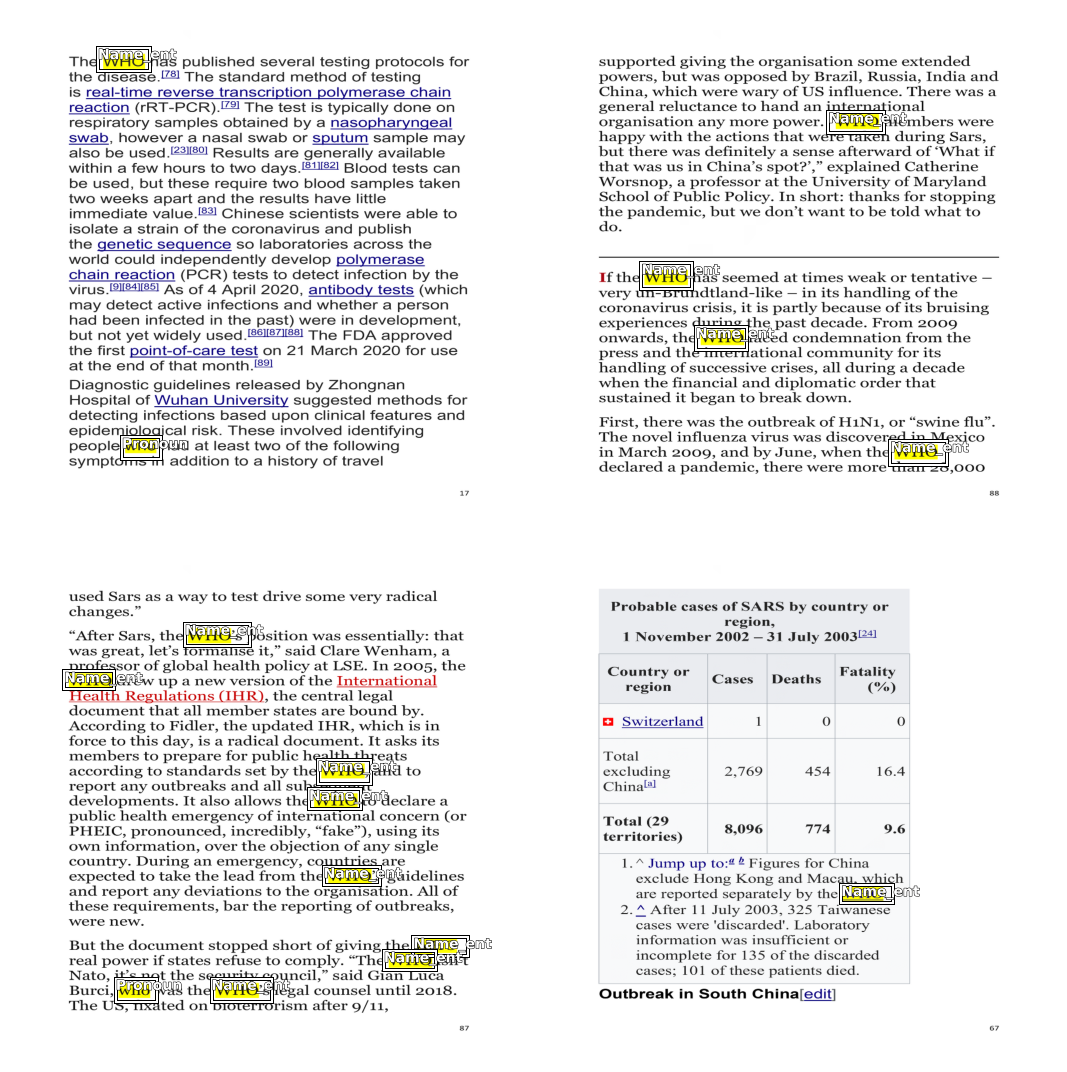

In [0]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(15,15))

In [0]:
anchors[0] 

tensor([-0.9688, -0.9688,  0.0277,  0.2767])

In [0]:
(data.valid_ds[0][0].data).shape

torch.Size([3, 512, 512])

In [0]:
# for i, bbox in enumerate(anchors[:10]):
#     print(bbox.shape)
#     bb = bbox.numpy()
#     print(bb.shape)
    
#     x = (bb[0] + 1) * size / 2 
#     print('x: ', x)
#     y = (bb[1] + 1) * size / 2 
#     print('y: ', y)
#     w = bb[2] * size / 2
#     print('w: ', w)
#     h = bb[3] * size / 2
#     print('j: ', h)

#     print()

In [0]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:24]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,h,w]    # used to be  [x,y,w,h]
    draw_rect(ax,rect, color='white')

## The objects on the left side are covered by anchors, where the right side shoes the objects that would be missed in training

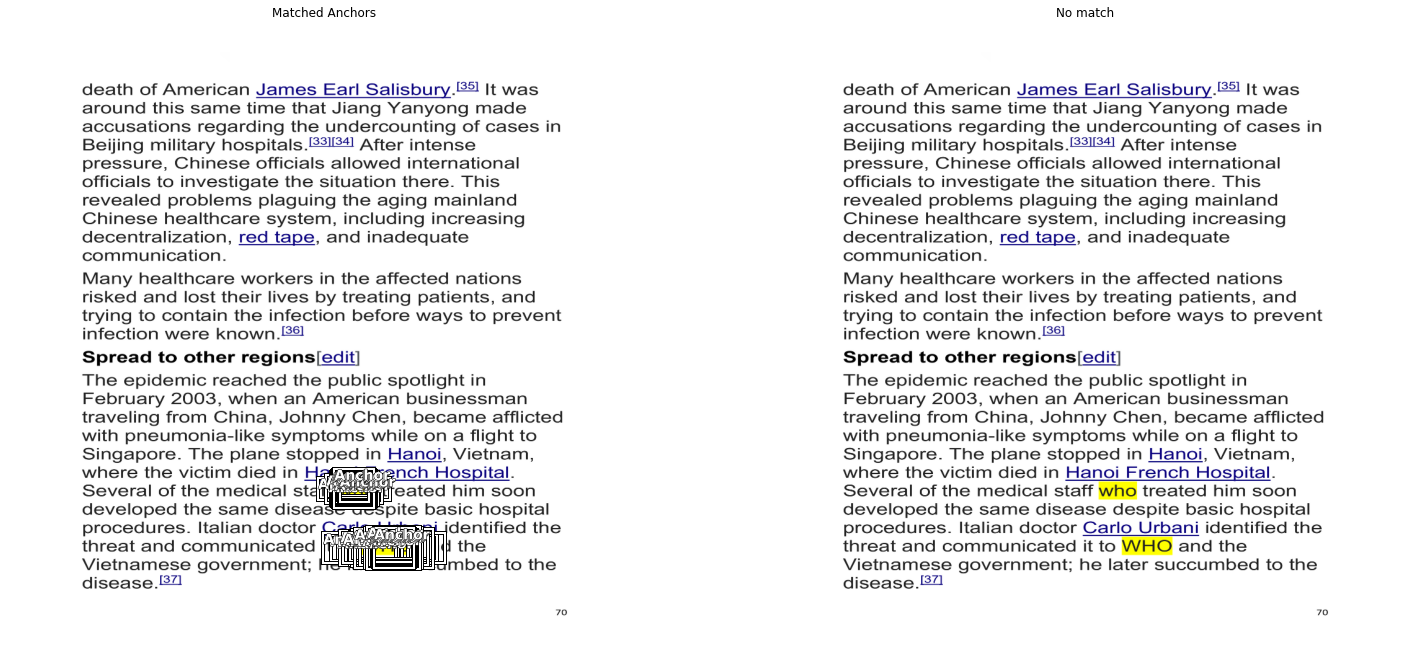

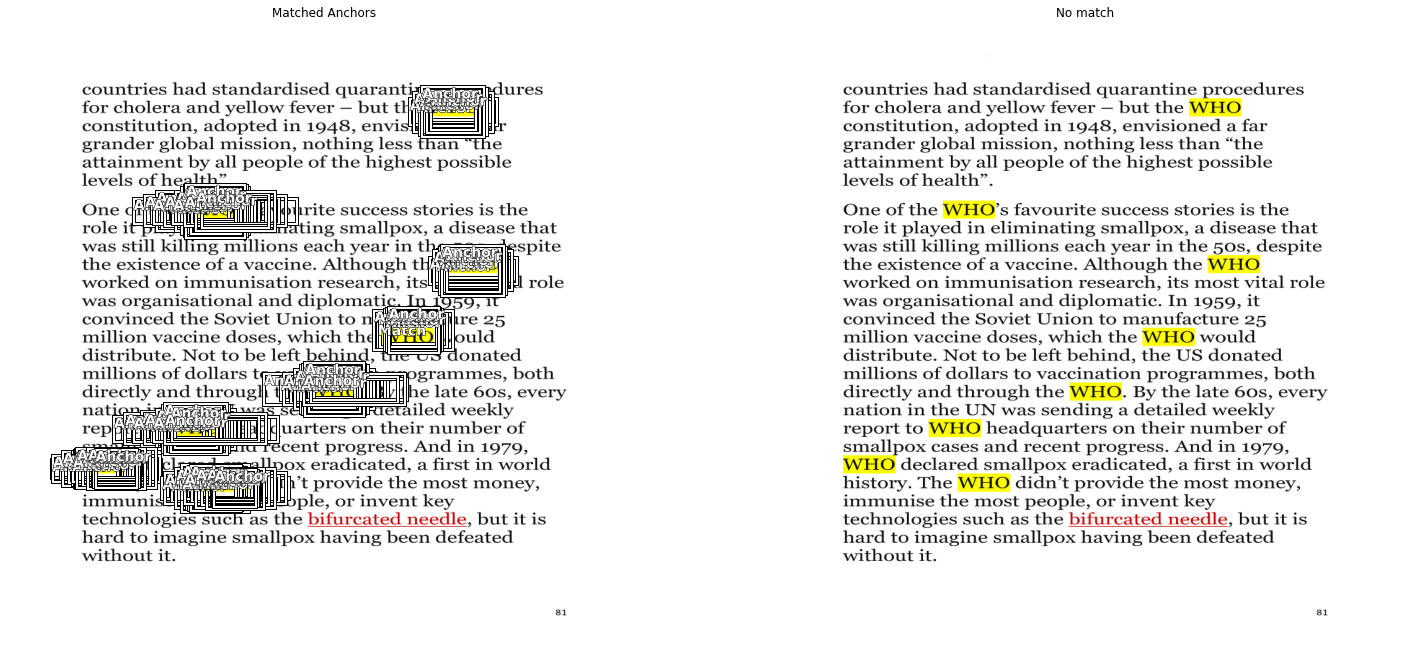

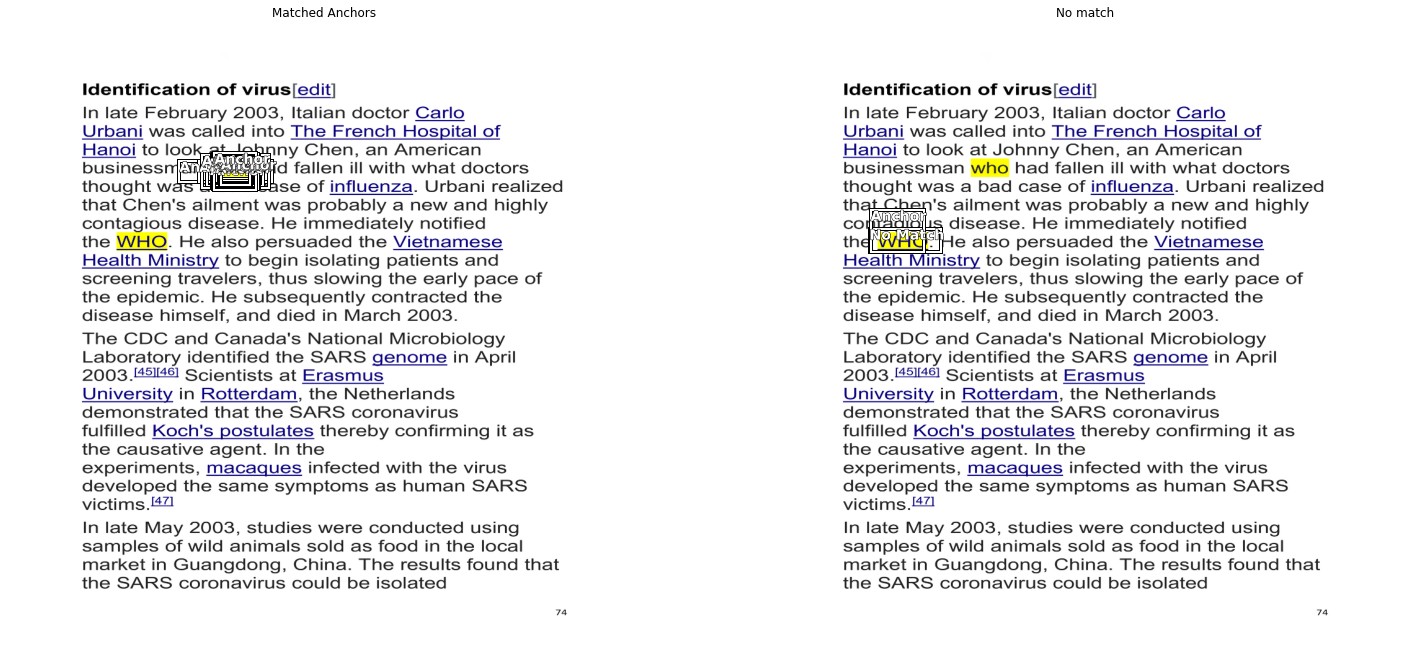

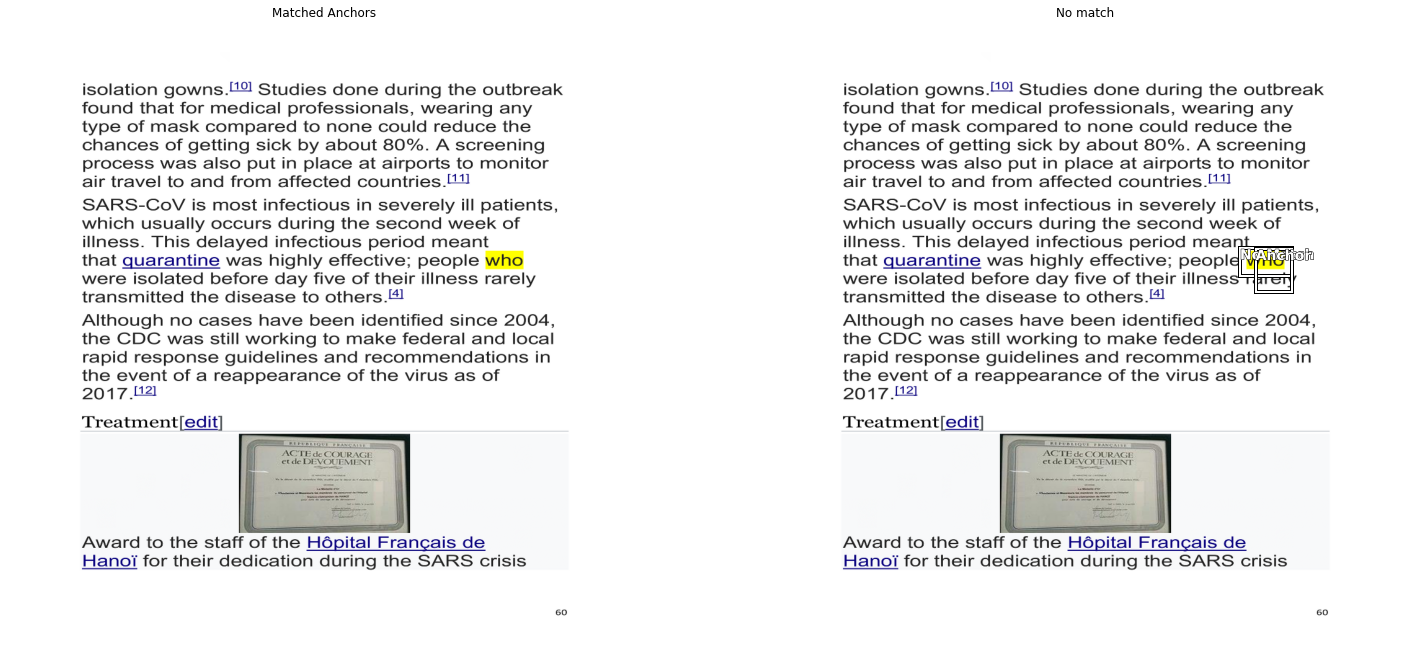

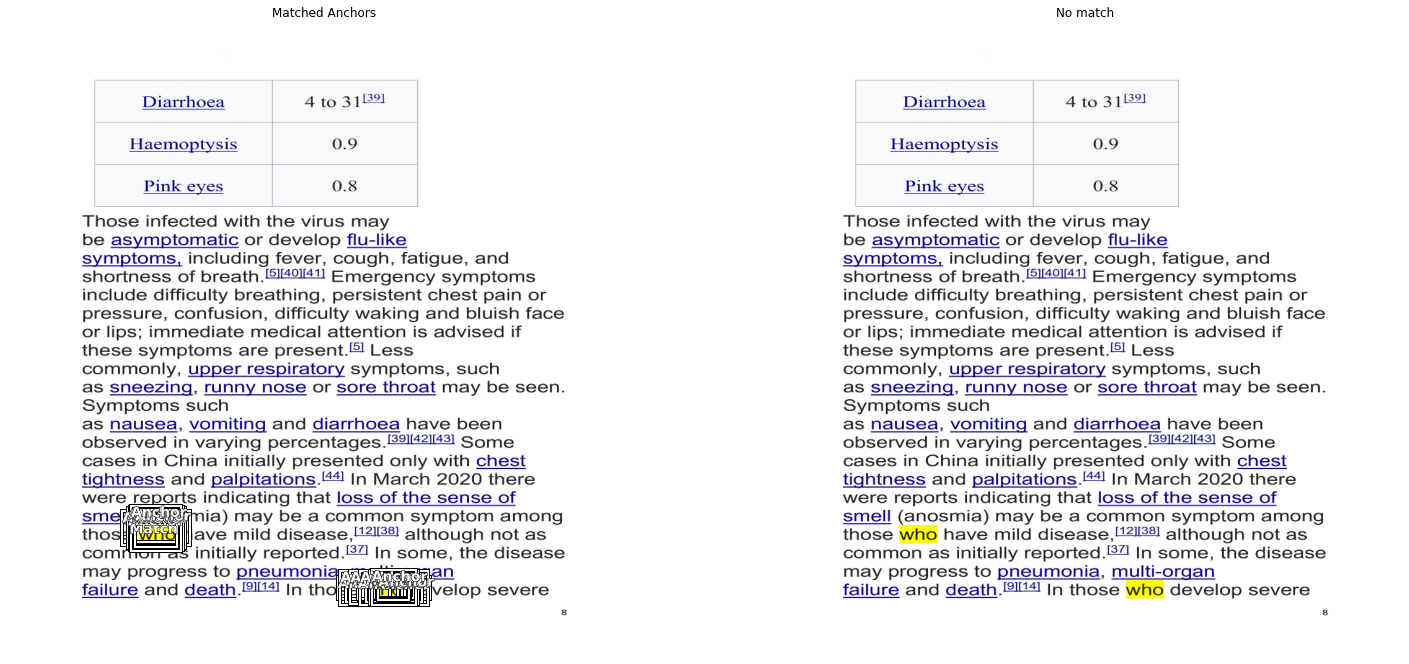

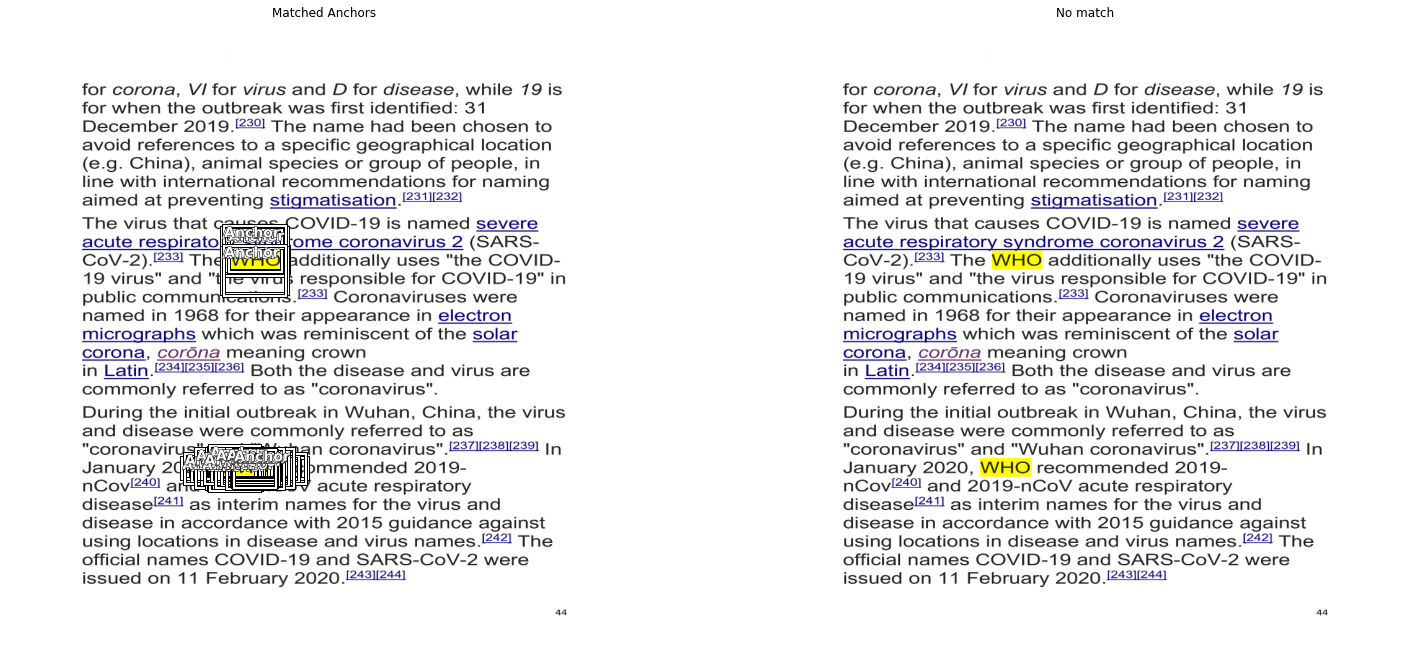

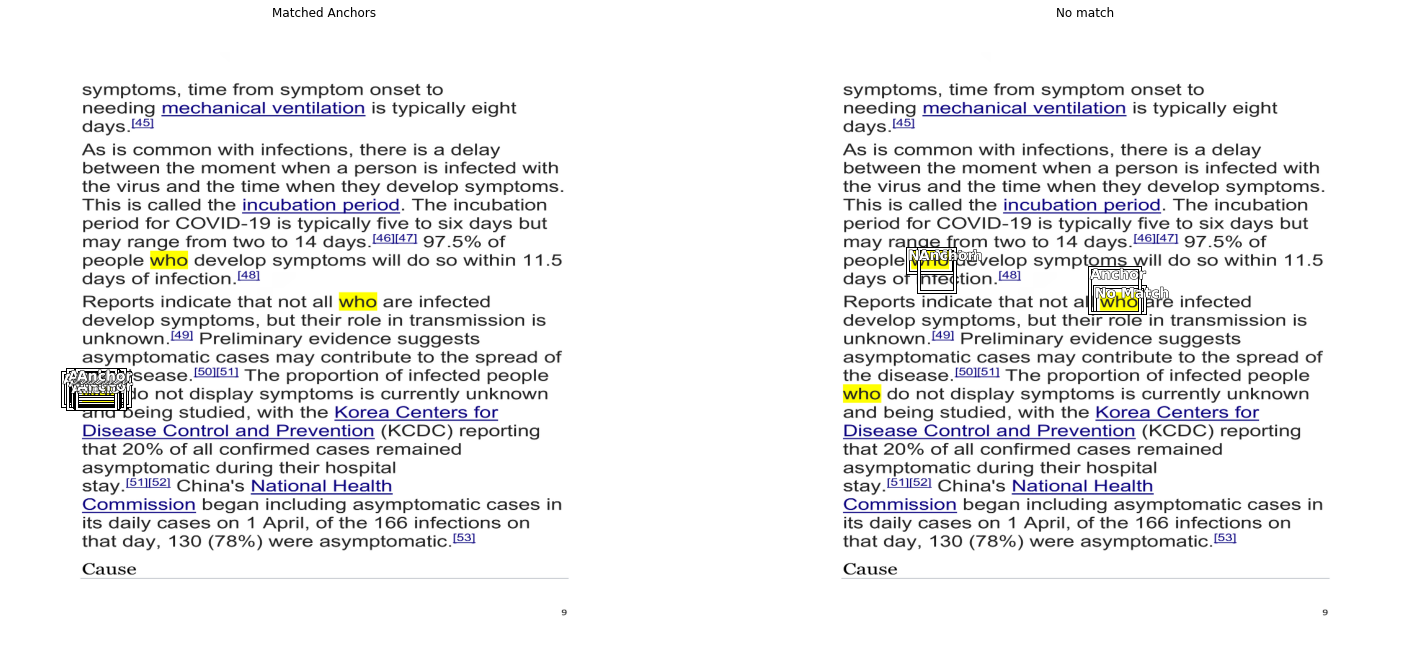

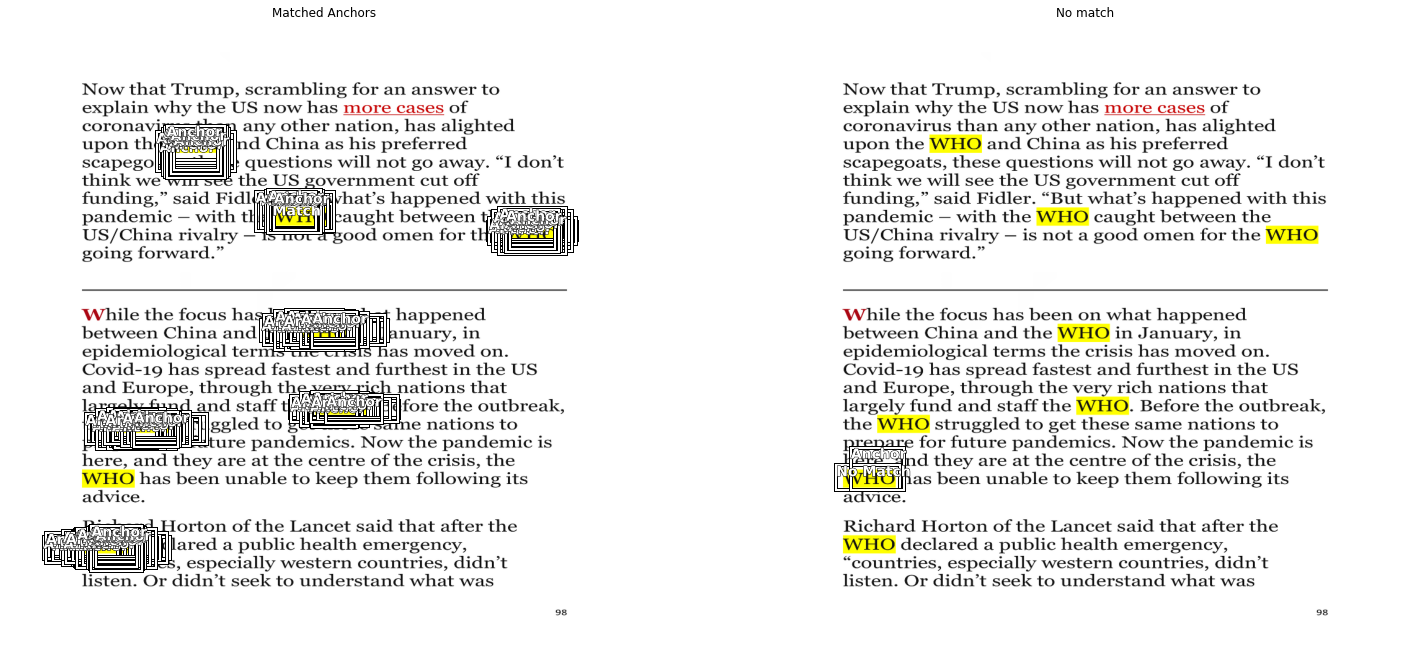

In [0]:
all_boxes, all_labels = show_anchors_on_images(data, anchors, figsize=(25,25))

## This is a cleaner representation of model.eval()

In [0]:
# def extract_all_layers(sequence, layers = []):
#     for child in sequence.children():
#         if isinstance(child, nn.Sequential): layers = extract_all_layers(child, layers)
#         else: layers.append(child)
#     return layers

# lls = extract_all_layers(model)
# lls

In [0]:
 [i for i in data.train_ds.y.classes[1:]]

['Name_ent', 'Pronoun']

In [0]:
n_classes =  data.train_ds.c 

voc = PascalVOCMetric(anchors, size, [i for i in data.train_ds.y.classes[1:]], detect_thresh=0.3, nms_thresh=0.3, images_per_batch=-1)
learn = Learner(data, model, loss_func= criterion, callback_fns=[ShowGraph, BBMetrics], metrics=[voc]) # not working .to_fp16()

In [0]:
learn.summary()

In [0]:
model.encoder

In [0]:
model.c5top5

Conv2d(512, 125, kernel_size=(1, 1), stride=(1, 1))

In [0]:
learn.split([model.encoder[6], model.c5top5])

In [0]:
  """ you can see these category classifier and bounding box regressor layers at the end of your model shown above"""
  """
  (classifier): Sequential(
    (0): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (2): Conv2d(512, 108, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (box_regressor): Sequential(
    (0): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (2): Conv2d(512, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  """

In [0]:
learn.summary()

In [0]:
learn.lr_find() #1e-5, 100)
learn.recorder.plot()

In [0]:
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


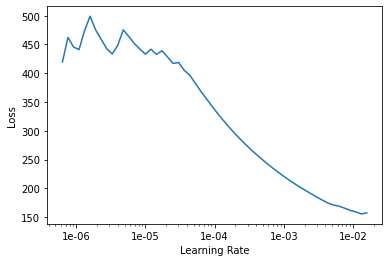

In [0]:
learn.fit_one_cycle(10, slice(1e-4/(3.6**4),1e-4), moms=(0.8,0.7))

In [0]:
# """  investigate this as well """
# x,y = next(iter(data.valid_dl))
# learn.model.eval()
# preds = to_np(learn.model(VV(x)))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


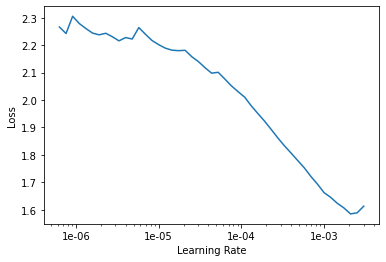

In [0]:
learn.lr_find()
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 11/11 [00:00<00:00, 29862.36it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 2/2 [00:00<00:00, 14665.40it/s]


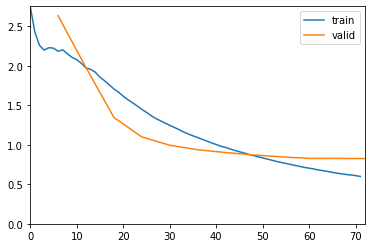

GT: 100%|██████████| 26/26 [00:00<00:00, 12808.54it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 28/28 [00:00<00:00, 54904.40it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 28/28 [00:00<00:00, 28062.25it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 29/29 [00:00<00:00, 16607.70it/s]
Detections: 0it [00:00, ?it/s]
GT: 100%|██████████| 10/10 [00:00<00:00, 23804.22it/s]


In [0]:
learn.freeze_to(-8) # unfreezing the last ...
learn.fit_one_cycle(12, slice(1e-4/(3.6**4),1e-4), moms=(0.8,0.7))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


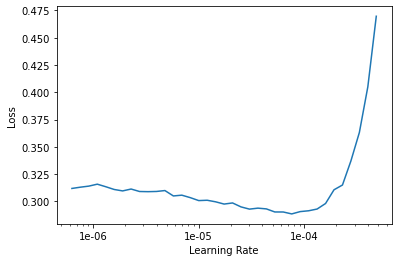

In [0]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 10/10 [00:00<00:00, 61680.94it/s]


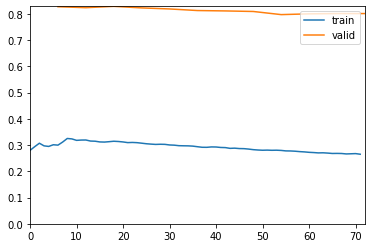

GT: 100%|██████████| 10/10 [00:00<00:00, 22857.24it/s]


In [0]:
learn.freeze_to(-16) # unfreezing the last...
learn.fit_one_cycle(12, slice(1e-5/(3.6**4),1e-5), moms=(0.8,0.7))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


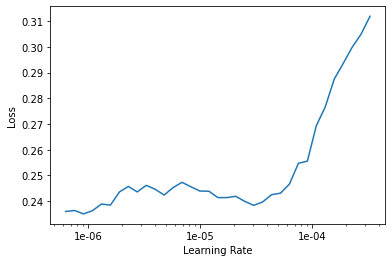

In [0]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|██████████| 10/10 [00:00<00:00, 15685.50it/s]


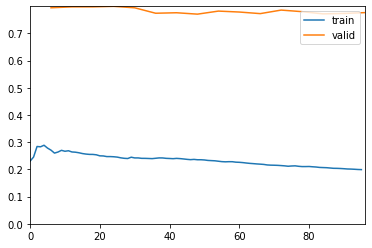

GT: 100%|██████████| 10/10 [00:00<00:00, 18404.14it/s]


In [0]:
learn.unfreeze()
learn.fit_one_cycle(16, slice(1e-5/(3.6**4),1e-5), moms=(0.8,0.7))

In [0]:
data.train_ds.classes

['background', 'Name_ent', 'Pronoun']

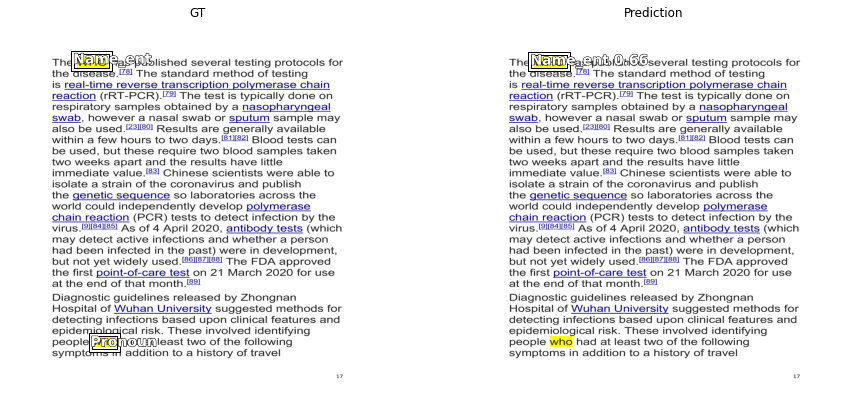

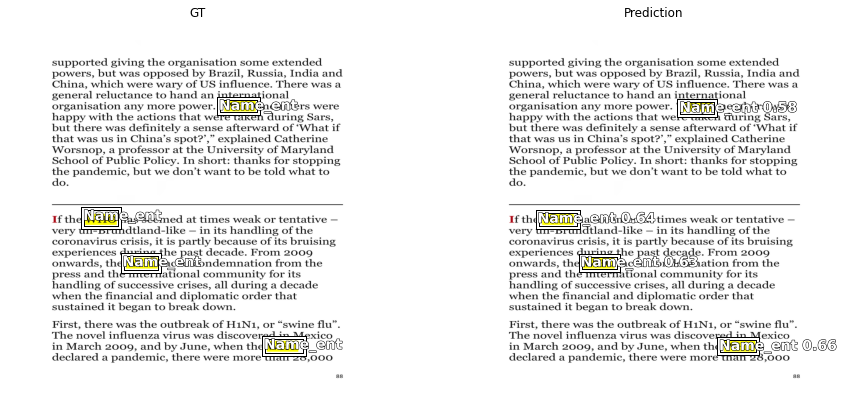

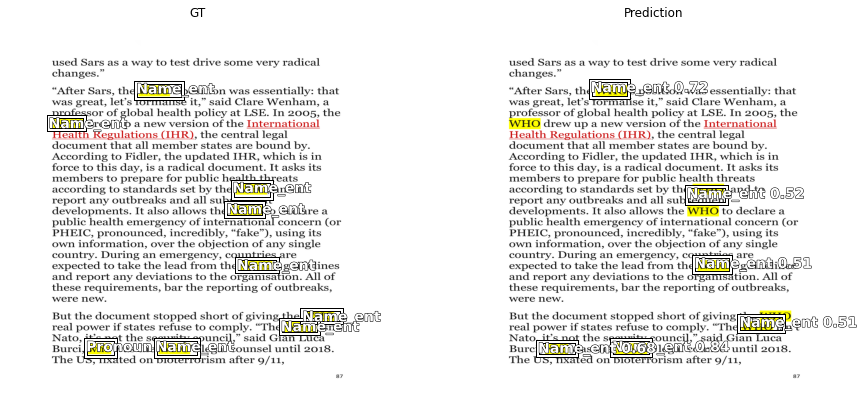

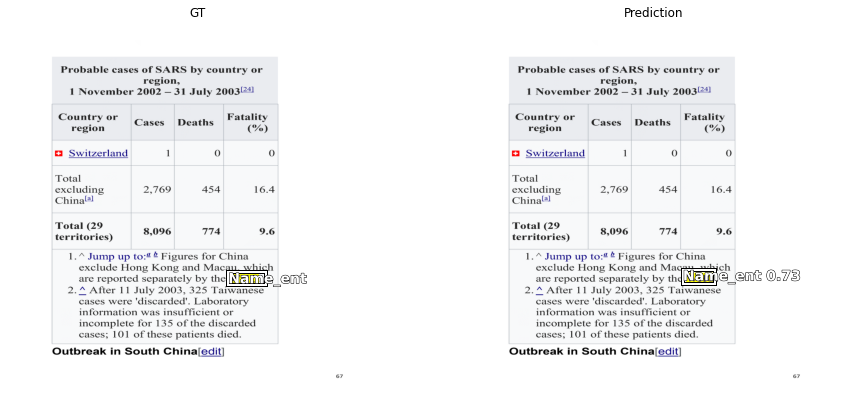

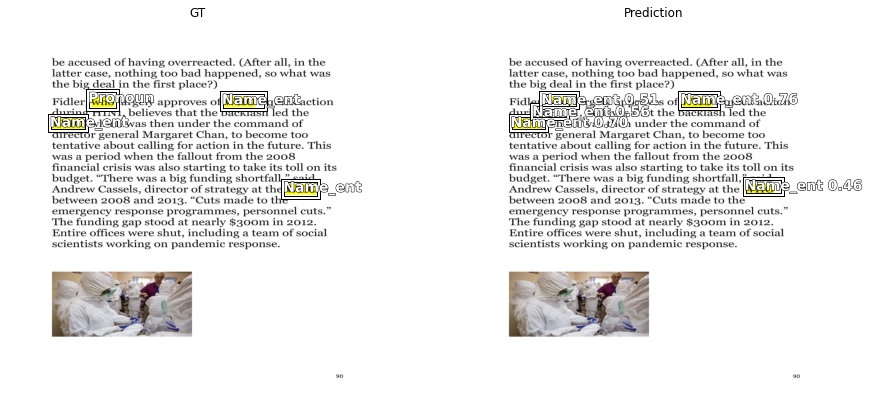

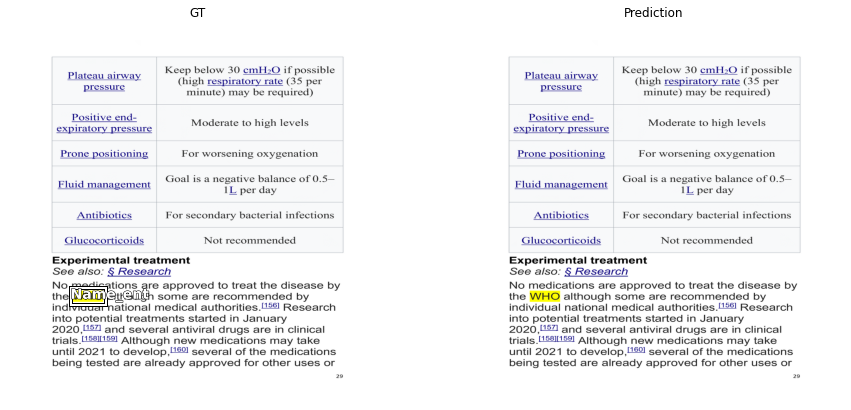

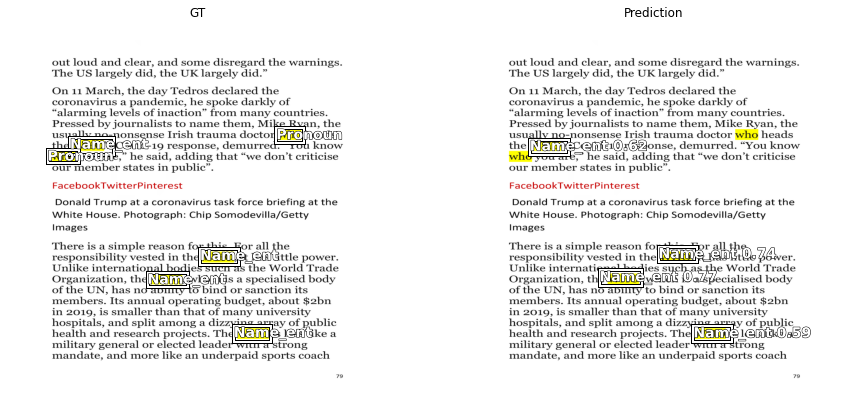

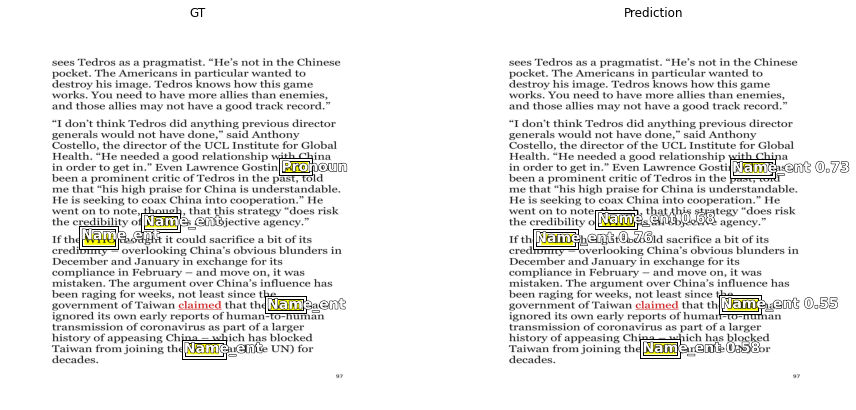

In [0]:
show_results_side_by_side(learn, anchors, detect_thresh=0.4, nms_thresh=0.1, image_count=10 )